In [335]:
import numpy as np
import scipy.optimize, scipy.io
import matplotlib.pyplot as plt
import copy

In [336]:
ex5data = scipy.io.loadmat("ex5data1.mat")

In [337]:
X_train, y_train = ex5data['X'], ex5data['y'].ravel()
X_test, y_test = ex5data['Xtest'], ex5data['ytest'].ravel()
X_cv, y_cv = ex5data['Xval'], ex5data['yval'].ravel()

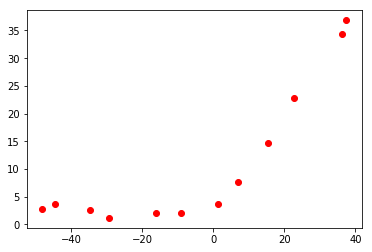

In [338]:
plt.scatter(X_train, y_train, color='red')

In [339]:
def h(theta, X):
    tmp_X = np.insert(X, 0, 1, axis=1)
    return tmp_X.dot(theta)

In [340]:
def J(theta, X, y, reg):
    m = X.shape[0]
    return 1/(2*m)*(np.linalg.norm(h(theta, X) - y))**2 + reg/(2*m)*(np.linalg.norm(theta[1:])**2)

In [341]:
J(np.ones(2), X_train, y_train, 1)

303.99319222026423

In [342]:
def gradJ(theta, X, y, reg):
    m = X.shape[0]
    tmp_theta = np.copy(theta)
    tmp_theta[0] = 0
    tmp_X = np.insert(X, 0, 1, axis=1)
    return 1/m*(tmp_X.transpose().dot(h(theta, X) - y)) + reg/m*tmp_theta

In [343]:
gradJ(np.ones(2), X_train, y_train, 1)

array([-15.30301567, 598.25074417])

In [344]:
theta_min = scipy.optimize.fmin_cg(lambda t: J(t, X_train, y_train, 0),
                                   np.ones(2),
                                   fprime=lambda t: gradJ(t, X_train, y_train, 0),
                                  ) 

Optimization terminated successfully.
         Current function value: 22.373906
         Iterations: 18
         Function evaluations: 28
         Gradient evaluations: 28


In [345]:
theta_min
x_plot = np.arange(-50, 40)
y_plot = theta_min[0] + theta_min[1]*x_plot

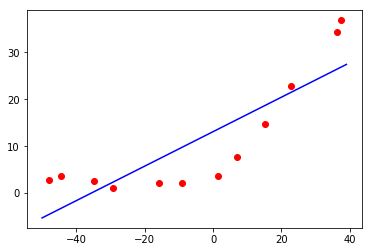

In [346]:
plt.scatter(X_train, y_train, color='red')
plt.plot(x_plot, y_plot, color='blue')

In [347]:
def poly_features(X, p):
    poly_X = copy.deepcopy(X)
    for i in range(2, p+1):
        poly_X = np.concatenate((poly_X, np.power(X, i)), axis=1)
    return poly_X

In [348]:
J(np.ones(4), poly_features(X_train, 3), y_train, 0)

1118460208.749629

In [349]:
def feature_normalize(X):
    subtract_mean = lambda x: x - np.mean(x)
    scale = lambda x: x/np.std(x)
    X_normalized = np.apply_along_axis(subtract_mean, 0, X)
    X_normalized = np.apply_along_axis(scale, 0, X_normalized)
    return X_normalized

In [350]:
J(np.ones(4), feature_normalize(poly_features(X_train, 3)), y_train, 0)

110.58321531946416

In [351]:
X_poly_norm = feature_normalize(poly_features(X_train, 8))
X_poly_norm.shape

(12, 8)

In [367]:
theta_min_0 = scipy.optimize.fmin_cg(lambda t: J(t, X_poly_norm, y_train, 0),
                                   np.ones(9),
                                   fprime=lambda t: gradJ(t, X_poly_norm, y_train, 0),
                                  ) 
theta_min_1= scipy.optimize.fmin_cg(lambda t: J(t, X_poly_norm, y_train, 1),
                                   np.ones(9),
                                   fprime=lambda t: gradJ(t, X_poly_norm, y_train, 1),
                                  ) 
theta_min_100= scipy.optimize.fmin_cg(lambda t: J(t, X_poly_norm, y_train, 100),
                                   np.ones(9),
                                   fprime=lambda t: gradJ(t, X_poly_norm, y_train, 100),
                                  ) 

Optimization terminated successfully.
         Current function value: 0.028895
         Iterations: 1601
         Function evaluations: 3065
         Gradient evaluations: 3065
Optimization terminated successfully.
         Current function value: 6.830463
         Iterations: 26
         Function evaluations: 45
         Gradient evaluations: 45
Optimization terminated successfully.
         Current function value: 65.950955
         Iterations: 9
         Function evaluations: 18
         Gradient evaluations: 18


In [378]:
x_plot0 = np.arange(-50, 40).reshape((90, 1))
x_plot0 = np.insert(feature_normalize(poly_features(x_plot0, 8)), 0, 1, axis=1)
y_plot0 = x_plot0.dot(theta_min_0)
x_plot0 = np.arange(-50, 40)
x_plot1 = np.arange(-50, 40).reshape((90, 1))
x_plot1 = np.insert(feature_normalize(poly_features(x_plot1, 8)), 0, 1, axis=1)
y_plot1 = x_plot1.dot(theta_min_1)
x_plot1 = np.arange(-50, 40)
x_plot100 = np.arange(-50, 40).reshape((90, 1))
x_plot100 = np.insert(feature_normalize(poly_features(x_plot100, 8)), 0, 1, axis=1)
y_plot100 = x_plot100.dot(theta_min_100)
x_plot100 = np.arange(-50, 40)

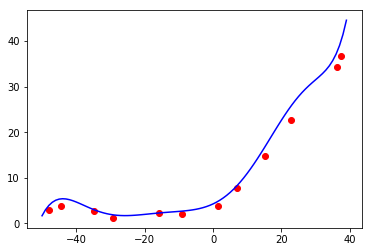

In [379]:
plt.scatter(X_train, y_train, color='red')
plt.plot(x_plot0, y_plot0, color='blue')

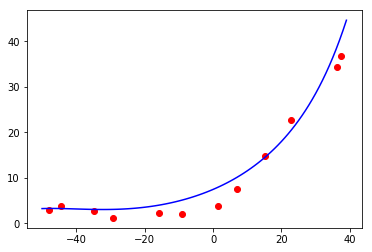

In [381]:
plt.scatter(X_train, y_train, color='red')
plt.plot(x_plot1, y_plot1, color='blue')

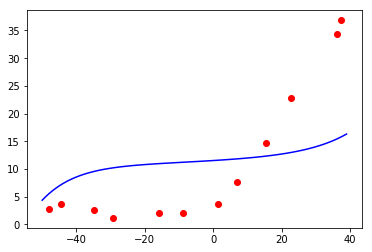

In [382]:
plt.scatter(X_train, y_train, color='red')
plt.plot(x_plot100, y_plot100, color='blue')